## Data Analysis of InstaCart Market Basket dataset

This notebook serves as my capstone project for the **[Google Data Analytics](https://www.coursera.org/account/accomplishments/verify/V34P7Z7TDP8M)** course, it'll read a little differently than the typical data analytics blog post that are highly technical but doesn't go into the analyst's train of thoughts. My goal is to make this an easily understandable document so anyone can read and understand how I go about investigating and finding meaning in big data as a data analyst.

I'll be using the "[InstaCart Market Basket](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=8da413602ddb)" dataset as an example. “The Instacart Online Grocery Shopping Dataset 2017” (https://www.instacart.com/datasets/grocery-shopping-2017) consists of 3 million grocery orders from more than 200,000 InstaCart users for its 50,000 unique products from various aisles and departments, and also includes information such as products ordered, the sequence in which they were added to the cart, the order day of the week and time of day when the order was placed. For information about the contents of the files, see this [data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*LNpbMMzWBsKqKyNvNH2APA.png)

First, I imported the data into Postgres for storage and to do some exploratory data analysis. EDA is important as it helps us understand the data better so we can ask better questions, which leads to better features engineering. 

So, let's first look at the ERD to see how the data relate to each other:

![](./InstaCart_ERD.png)

The **orders** table is what ties everything together, it has 3.4m rows, with 206k unique users. It's connected to the **order_products_prior** table, which has 32m rows! That's all the past orders that has been placed. In comparison, the **order_products_train** table only has 1.3m rows in it, I guess they took the last few orders in their database, remove a few items from the end of each order, and put it here for the purpose of training new machine learning models? We're not gonna go into that here. Finally, there are 50K rows in **products**, which belong in 134 **aisles** and 21 **departments**. It's good practice to know the basic info of the dataset so that you'll know when the numbers don't add up.

Now that we have some basic knowledge about the dataset, what would be some meaningful ways to look into it? I try to put myself in the shoes of InstaCart's managers and come up some questions I would like answered. e.g.

1. What are some different types of customers of InstaCart? How can we put them into different segments?
2. What are the most / least popular products across the site and in each department?
3. Are there popular sets of products that are often purchaesd together?
4. When do users do their shopping? When is the busiest / least busy time for the site?
5. How many users are repeated buyers? What are the differences between the most / least loyal customers?
6. Who are our top Customer Lifetime Value (CLV) customers? What differentiate them with the lower CLV users?

You can see that by answering these questions, management (hopefully) can make the right decisions on where to put resources in to improve the business. So, next, I would usually check with the product team, prioritize the above questions and add / subtract any questions as we see fit. Then, for each question, I'll come up with some hypothesis - __*"if we can find X, then it'll help us make decision on Y"*__ kind of statements. e.g.

1. **Customer Segmentation**: We can analyze customer behavior to identify different customer segments based on shopping patterns (when do they shop?), order frequency (how many days between each order?), and product preferences (what do they buy?). If we can create these segments, they can help us tailor marketing campaigns and improve customer retention.

2. **Product Associations**: Discover frequent product sets and association rules between products to identify items that are often bought together. This is called **Frequent Itemset Mining** (FIM) and supermarkets have been using these data mining techniques to analyze the user buying pattern. If we discover common product pairs, they can be used to create product bundles or develop targeted promotions, such as recommending additional items during the checkout process.

    (Product association heat map.)

3. **Popular Products**: Identify the most popular products in different aisles and departments. If we can keep a good record of popular product and how fast they sell, we can better manage our inventory and prioritize partnerships with suppliers.

    - Not just all time total. Try segmenting by time to discover sell rate for better inventory logistic.
    - Aisle and Department Popularity: Examine the sales volume and revenue generated by different aisles and departments, and identify the most and least popular categories.

4. **Day and Time of Orders**: Examine the days of the week and times of day when customers are most likely to place orders. If we can find out when our customers do most of their shopping, that'll help us better optimize our staffing and delivery schedules.

    - Order Frequency and Timing: Determine the most popular days and times for placing orders, and assess the impact of promotions on order frequency.
    - [Chart given by InstaCart on their blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=6f9dfbde5136) is very interesting - Sum of each product sold group by hour of day.

I try to make the flow of investigation as logical as possible, but please note that in reality, it's not such a straight path at all! We take our hypothesis, and we make discoveries. Often times they're out of our expectations and lead to nowhere. Then we have to go back and take a different path. So, one important quality of a good data analyst is "focus"! Focus on the North Star, so that even when it looks like you're meandering all over the map, you are actually keeping your eye on the goal and when a meaningful insight or connection pops up, you'll know to capture it.

In this example, I'll demonstrate looking deeper into customer segments first. I would imagine there are csutomers who are higher value to the company, e.g. Users who make repeated orders more often, or in less time than mean. Users who make higher dollar amount orders (although that data isn't given here). etc… Once we've identify a high valued customer segment, then I would look for patents - shopping time, product sets, anything that shows a difference between this group of users Vs. lower valued groups. I think that would make a good demonstration.

### 1. Customer Segmentation

So we want to identify customers who have higher CLV to the company, ie. they make repeated orders more often, or they make orders of higher dollor amount. Since dollar amount data is not provided in this dataset, we'll just have to concentrate on more frequent repeat orders then.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the orders dataset
orders = pd.read_csv("orders.csv")


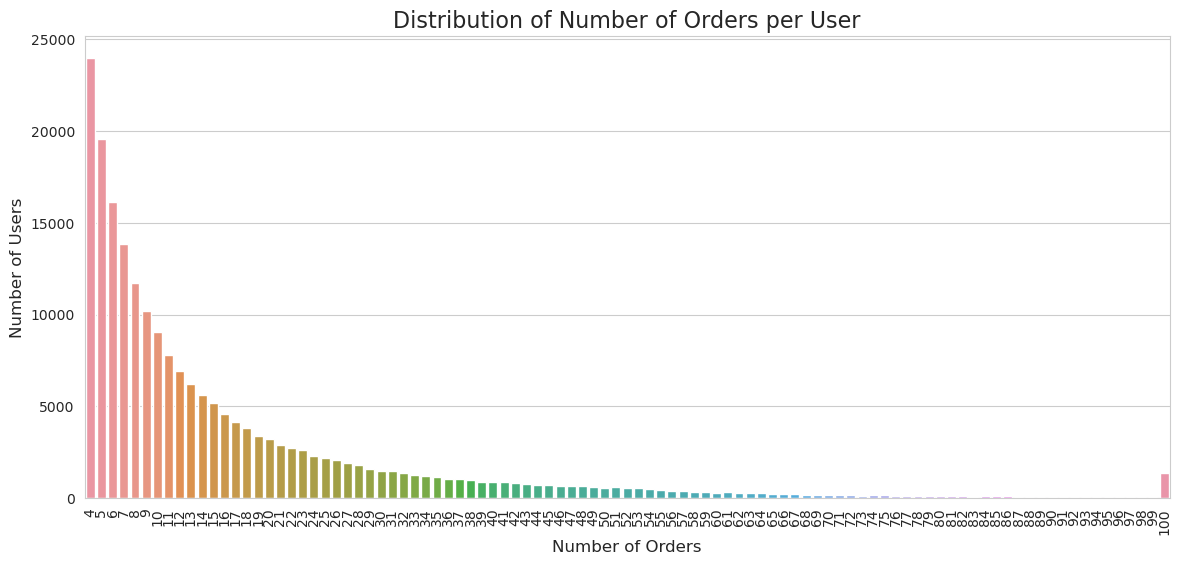

In [25]:
# Group by user_id and count the number of orders
order_counts = orders.groupby("user_id")["order_id"].count().reset_index()
order_counts.rename(columns={"order_id": "number_of_orders"}, inplace=True)

# Create the count plot
plt.figure(figsize=(14, 6))
sns.countplot(x="number_of_orders", data=order_counts)

# Set plot title and labels
plt.title("Distribution of Number of Orders per User", fontsize=16)
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)

# Rotate x-axis tick labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

Looks like most users make less than 15 orders, and then the chart flattens out so less and less users make more orders, until we reach 100 where there's a spike. Why is that? My guess is that InstaCart modified the data so that the max is capped at 100 orders per user. Let's take a look at the data.

In [26]:
order_counts[order_counts["number_of_orders"] > 99]

,user_id,number_of_orders
209,210,100
309,310,100
312,313,100
689,690,100
785,786,100
...,...,...
205482,205483,100
205542,205543,100
205877,205878,100
205971,205972,100


Yup. OK, what next? We're trying to identify customers who have higher CLV, besides "total number of orders", we can also look at how often repeated orders were made. It made also be intersting to see the size of the order, since we don't have the dollar amount to play with, that's the next best thing. Let's create a chart the see the relationship between number of orders and "days since last order".

Let's start with how often repeated orders were made. So, we're looking at an average of "days_since_prior_order" per user_id. Like this:

`orders.groupby("user_id")["days_since_prior_order"].mean()`

We can put the two together like this:

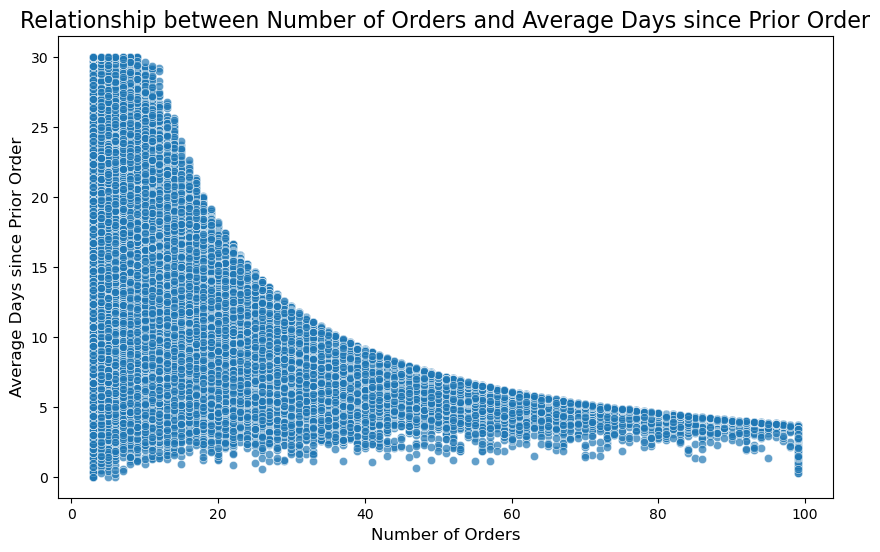

In [25]:
# Exclude the first order for each user
orders = orders[orders["days_since_prior_order"].notna()]

# Group by user_id and calculate the average days_since_prior_order and total orders
user_order_stats = orders.groupby("user_id").agg({"days_since_prior_order": "mean", "order_id": "count"}).reset_index()
user_order_stats.rename(columns={"days_since_prior_order": "avg_days_since_prior_order", "order_id": "total_orders"}, inplace=True)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="total_orders", y="avg_days_since_prior_order", data=user_order_stats, alpha=0.7)

# Set plot title and labels
plt.title("Relationship between Number of Orders and Average Days since Prior Order", fontsize=16)
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Average Days since Prior Order", fontsize=12)

# Show the plot
plt.show()

That looks interesting. It looks pretty similar to the last chart about total number of orders per user. Here we can see that as the total number of orders grow, the average days since prior order decreases to under ~10 days. It's always good to dig in and look at individual samples, just to make sure you understand on the individual record level.

In [22]:
user_order_stats[user_order_stats['avg_days_since_prior_order'] < 10]

,user_id,avg_days_since_prior_order,total_orders
12,13,7.666667,12
16,17,8.000000,40
17,18,5.833333,6
18,19,9.333333,9
26,27,4.432099,81
...,...,...,...
206192,206193,5.780488,41
206194,206195,8.000000,19
206199,206200,8.826087,23
206205,206206,3.716418,67


In [23]:
orders[orders['user_id']==206195]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3420763,2269302,206195,prior,2,6,16,3.0
3420764,3141208,206195,prior,3,4,17,5.0
3420765,2439561,206195,prior,4,0,9,3.0
3420766,2243155,206195,prior,5,2,14,2.0
3420767,821831,206195,prior,6,6,14,4.0
3420768,1671452,206195,prior,7,1,17,2.0
3420769,2932380,206195,prior,8,6,11,5.0
3420770,3399187,206195,prior,9,2,16,3.0
3420771,274302,206195,prior,10,5,15,3.0
3420772,1289634,206195,prior,11,2,15,25.0


For example, user 206195 has made a total of 20 orders, you can see that in the beginning, it tooks less than 5 days for this user to make another order, but something happend after the 10th oder and this user started to lapse for 25 days before ordering again. That's interesting! May be we can look into why some users slowed down, you should keep a record of "interesting data points to investigate", this will become your backlog to work on later.

For now, we should concentrate on our original goal. We can make an assumption like "users who make more than a total of 90 orders", (which also means the users who make reorders under 7 days on average) are high in CLV, and users who have made less than 15 orders, with an average order frequency of more than 27 days are low in CLV. Now we can move on to 2. **Product Associations** and run **Frequent Itemset Mining** (FIM)!

You may ask, "__Hey! Why didn't you just start with FIM?__" Most people when they see a market basket problem, they'll jump straight to running the Apriori algorithm to mine frequent itemsets and discovering association rules. In fact, this is often what you'll see on data analysis posts on the internet, people going through a dataset by going through many different codes and algorithms, as if that's what data analysis is all about. I can tell you that analysts like that add no value to the organization they work for! Imagine you're the VP of product or marketing, and the analyst just gives you an updated version of many different charts. Look impressive, but what can you do with the info besides looking at the pretty visuals and identifying outliers? Not much.

Instead, what I've done here is a weaving story - a logical journey of discoery. When we finally arrive at FIM between high and low CLV users, the VPs know exactly what we're looking at and how we've arrived there. They can take that high quality insight and make decisions with higher confidence. That's delivering value as a data analyst! Now let's see the product associations for customers who've made over 90 orders:


In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

# Load order_products, products, and orders data
order_products = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders.csv")

# Filter users who made over 90 orders
user_order_counts = orders.groupby("user_id")["order_id"].count()
users_over_90_orders = user_order_counts[user_order_counts > 90].index

# Filter orders for above users
filtered_orders = orders[orders["user_id"].isin(users_over_90_orders)]


/opt/conda/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
filtered_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3165,3264342,210,prior,1,0,12,NaN
3166,2420729,210,prior,2,3,7,3.0
3167,2844082,210,prior,3,6,11,3.0
3168,1751757,210,prior,4,0,13,1.0
3169,2531142,210,prior,5,3,7,3.0
...,...,...,...,...,...,...,...
3419497,2233698,206105,prior,96,2,17,1.0
3419498,1211365,206105,prior,97,4,17,2.0
3419499,1279578,206105,prior,98,5,20,1.0
3419500,3367002,206105,prior,99,6,7,1.0


In [2]:
# The result has 187736 ordres, which will need too much RAM to run FIM.
# Instead, we'll get a sample of orders to reduce the size of the dataset
sample_order_ids = filtered_orders["order_id"].drop_duplicates().sample(30000, random_state=42)
sample_order_products = order_products[order_products["order_id"].isin(sample_order_ids)]

In [3]:
sample_order_products

,order_id,product_id,add_to_cart_order,reordered
664,79,4210,1,1
665,79,4377,2,1
666,79,39461,3,1
667,79,13627,4,1
668,79,13110,5,1
...,...,...,...,...
32434398,3421069,21137,8,1
32434399,3421069,30391,9,1
32434400,3421069,18656,10,1
32434401,3421069,26940,11,1


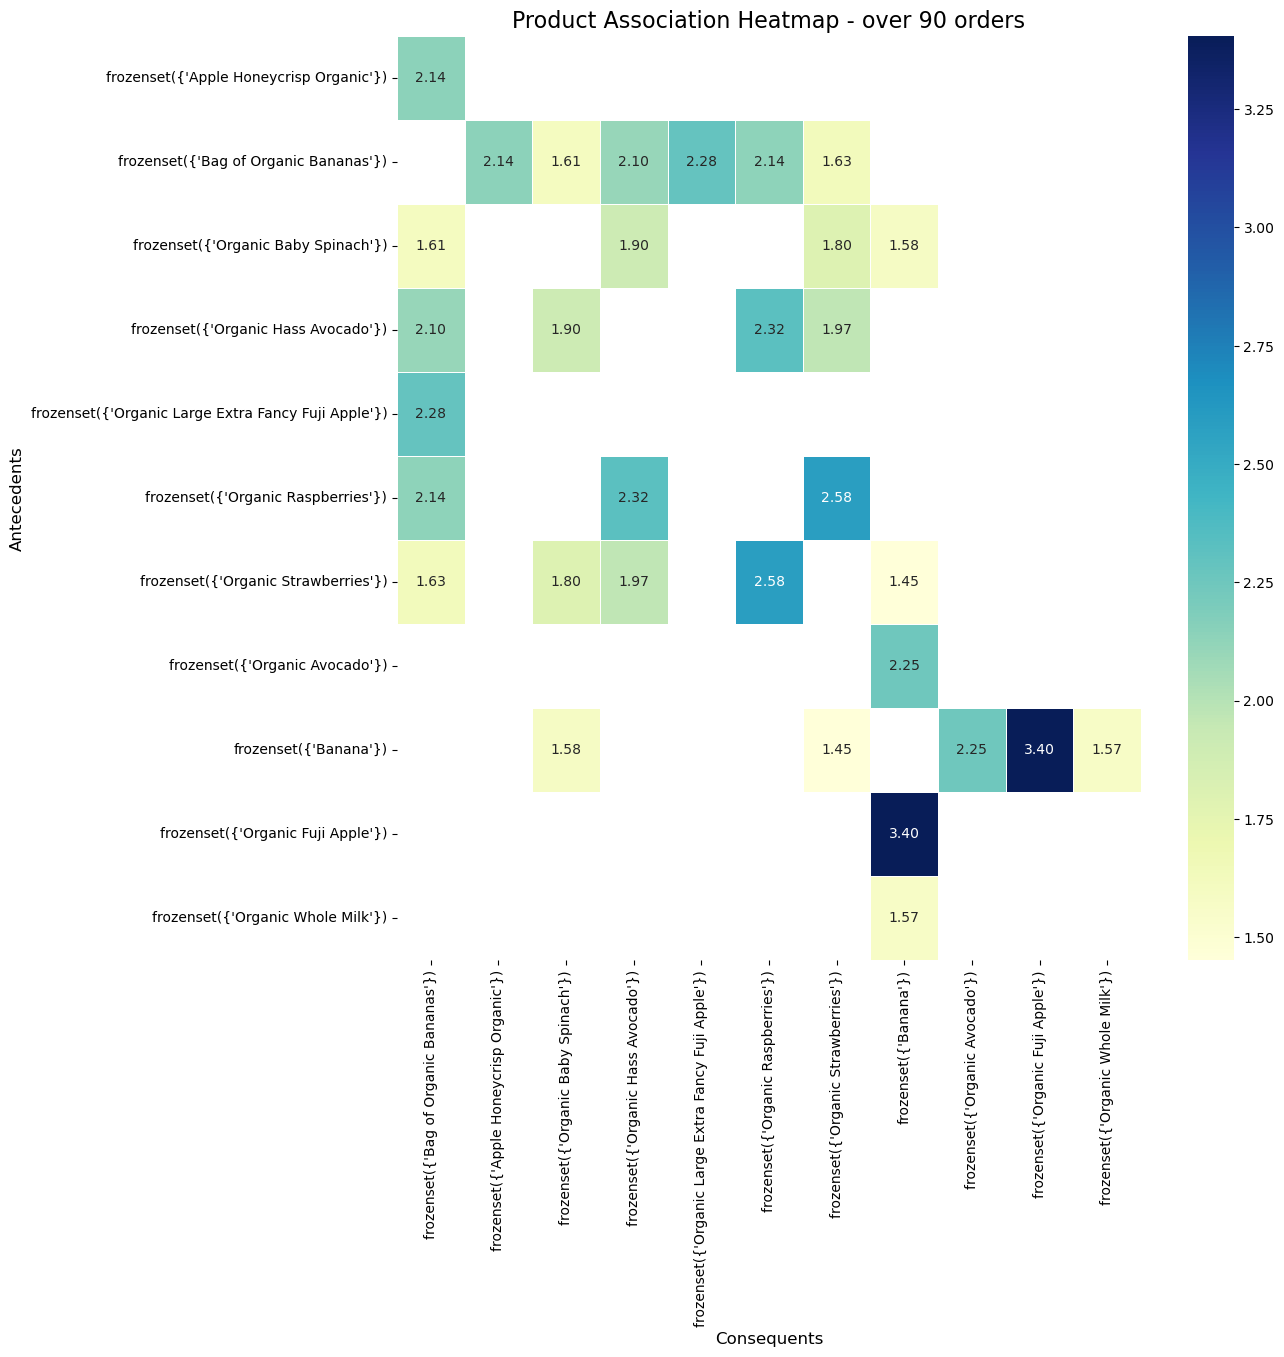

In [4]:
'''
Initialize an empty list called transactions to store a list of product names for each order.
Group the DataFrame by unique order IDs, loop iterates over order IDs and its corresponding group of rows 
This list of product names is then used for encoding and further analysis using the Apriori algorithm.
'''
transactions = []
for order_id, group in sample_order_products.groupby("order_id"):
    transactions.append(list(products.loc[products["product_id"].isin(group["product_id"]), "product_name"]))

# Encode the transactions
encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Calculate frequent itemsets
frequent_itemsets = apriori(transactions_df, min_support=0.01, use_colnames=True)

# Calculate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Create a pivot table for the heatmap
heatmap_data = rules.pivot_table(index="antecedents", columns="consequents", values="lift", aggfunc="max")

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Product Association Heatmap - over 90 orders", fontsize=16)
plt.xlabel("Consequents", fontsize=12)
plt.ylabel("Antecedents", fontsize=12)
plt.show()

Now let's compare the above to customers who reorder after 27 days on average.

In [5]:
# Find the average days_since_prior_order for each user
user_avg_last_order = orders.groupby("user_id").agg({"days_since_prior_order": "mean"}).reset_index()
user_avg_last_order.columns = ["user_id", "avg_days_since_prior_order"]

# Merge orders with user_avg_last_order
orders_with_avg_last = orders.merge(user_avg_last_order, on="user_id")

# Filter for users with avg_days_since_prior_order > 27
filtered_orders_over_27 = orders_with_avg_last[orders_with_avg_last["avg_days_since_prior_order"] > 27]
filtered_orders_over_27

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,avg_days_since_prior_order
297,2610576,25,prior,1,1,14,NaN,30.0
298,2994388,25,prior,2,1,20,30.0,30.0
299,258751,25,prior,3,5,19,30.0,30.0
300,1411408,25,test,4,0,15,30.0,30.0
624,1359969,44,prior,1,0,7,NaN,30.0
...,...,...,...,...,...,...,...,...
3420920,395144,206203,prior,2,0,18,30.0,29.4
3420921,3349091,206203,prior,3,2,13,30.0,29.4
3420922,1333145,206203,prior,4,1,16,27.0,29.4
3420923,133582,206203,prior,5,5,18,30.0,29.4


Cool! That only gave us 64172 rows. A lot less than the 187736 rows we got from users with over 90 orders.

In [6]:
# Get a sample of orders to reduce the size of the dataset
sample_27_order_ids = filtered_orders_over_27["order_id"].drop_duplicates().sample(30000, random_state=42)
sample_27_order_products = order_products[order_products["order_id"].isin(sample_27_order_ids)]
sample_27_order_products

,order_id,product_id,add_to_cart_order,reordered
998,110,5876,1,0
999,110,35951,2,0
1000,110,9450,3,0
1001,110,26216,4,0
1002,110,21405,5,0
...,...,...,...,...
32434403,3421071,26919,1,0
32434404,3421071,21791,2,0
32434405,3421071,35921,3,0
32434406,3421071,32293,4,1


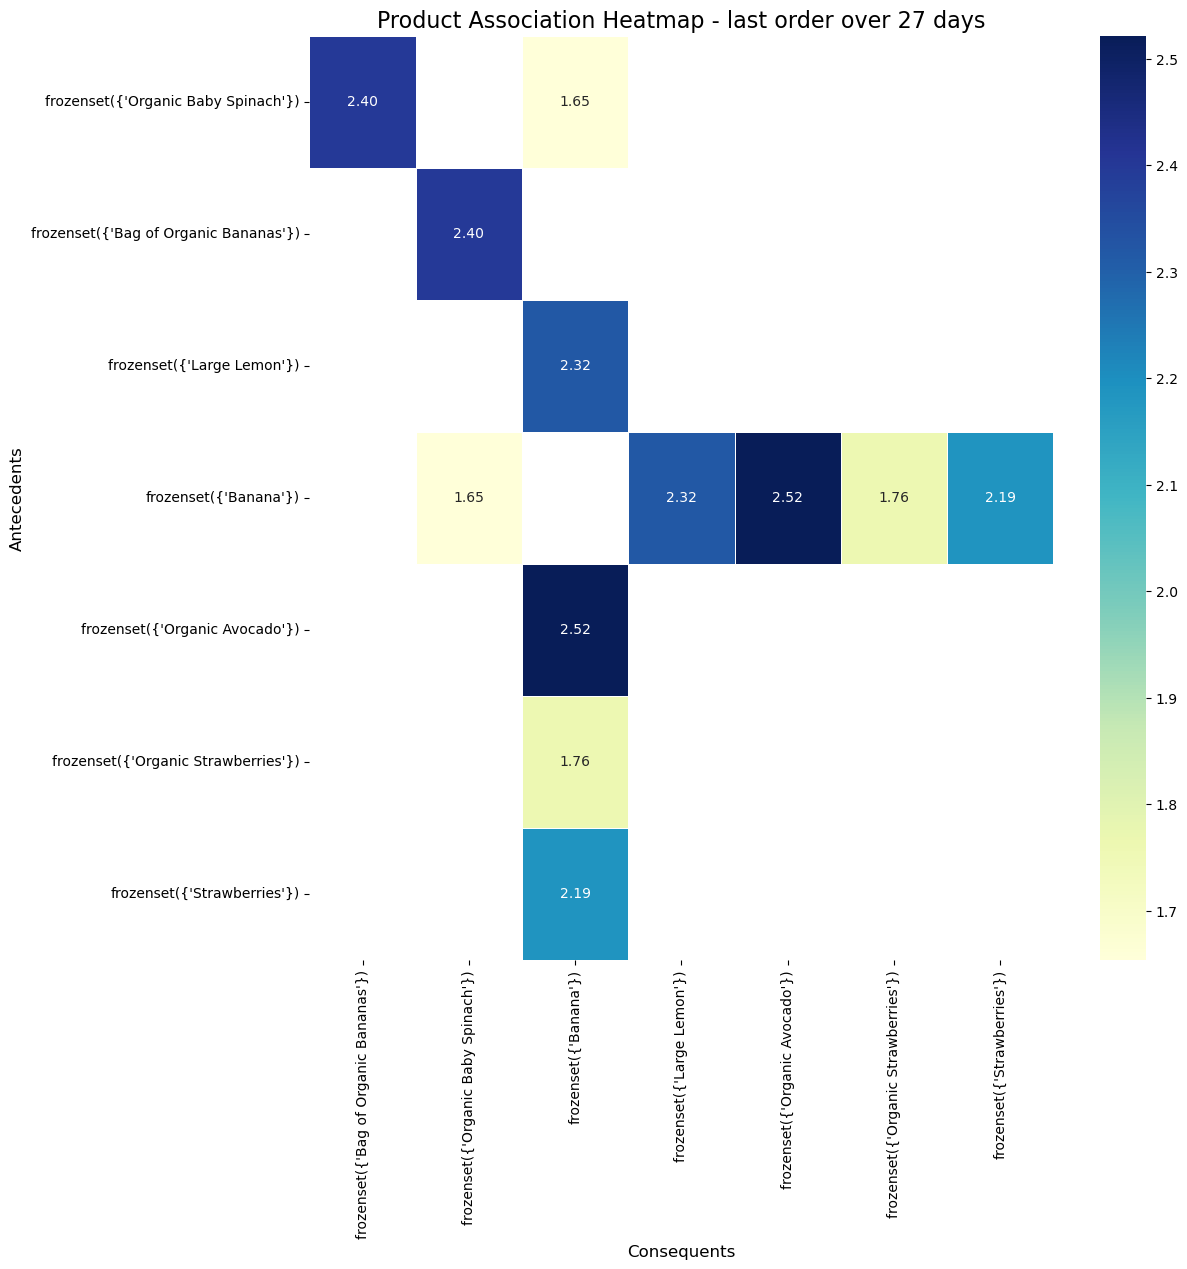

In [7]:
# Create a list of transactions (lists of product names)
transactions27 = []
for order_id, group in sample_27_order_products.groupby("order_id"):
    transactions27.append(list(products.loc[products["product_id"].isin(group["product_id"]), "product_name"]))

# Encode the transactions
encoder27 = TransactionEncoder()
transactions27_encoded = encoder27.fit_transform(transactions27)
transactions27_df = pd.DataFrame(transactions27_encoded, columns=encoder27.columns_)

# Calculate frequent itemsets
frequent_itemsets27 = apriori(transactions27_df, min_support=0.01, use_colnames=True)

# Calculate association rules
rules27 = association_rules(frequent_itemsets27, metric="lift", min_threshold=1)

# Create a pivot table for the heatmap
heatmap27_data = rules27.pivot_table(index="antecedents", columns="consequents", values="lift", aggfunc="max")

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap27_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Product Association Heatmap - last order over 27 days", fontsize=16)
plt.xlabel("Consequents", fontsize=12)
plt.ylabel("Antecedents", fontsize=12)
plt.show()

Now we've done a proper data analysis! We've created a hypothesis that repeated customers - customers who've made over 90 orders, are of higher customer lifetime value (CLV) than other users. We segmented users to look at two extremes - the customers who've made over 90 orders, and the customers whose average days since last order is over 27 days. With these 2 segments on hand, we did a Frequent Itemset Mining and found that there are differences in the item pairs of these two sets of users.

Now we can report our findings with suggestions for action! For example, the high CLV group bought bananas and organic fuji apples together, whereas the lower CLV group doesn't. (They bought bananas too but their strongest pair with that is organic avacado.) So, may be we can suggest the users to buy fuji apples when they add bananas into their basket.

Cool! This is only **one** run through as an example. Data analysis is detective work and it's so much fun to turn the data around and dissect it in different ways. And when you've found something that's especially useful, then you can tidy up / refactor your code and build a dashboard so that the stakeholders can access the analysis online.

----

# END

# Scrap Notes Below

----

Things didn't go as smoothly in real life. I had wandered down a different path looking into "when users make their ordres", thinking that may be a way to segment the users. It didn't lead anywhere, so I had to abandon it, but here's what I had done.

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


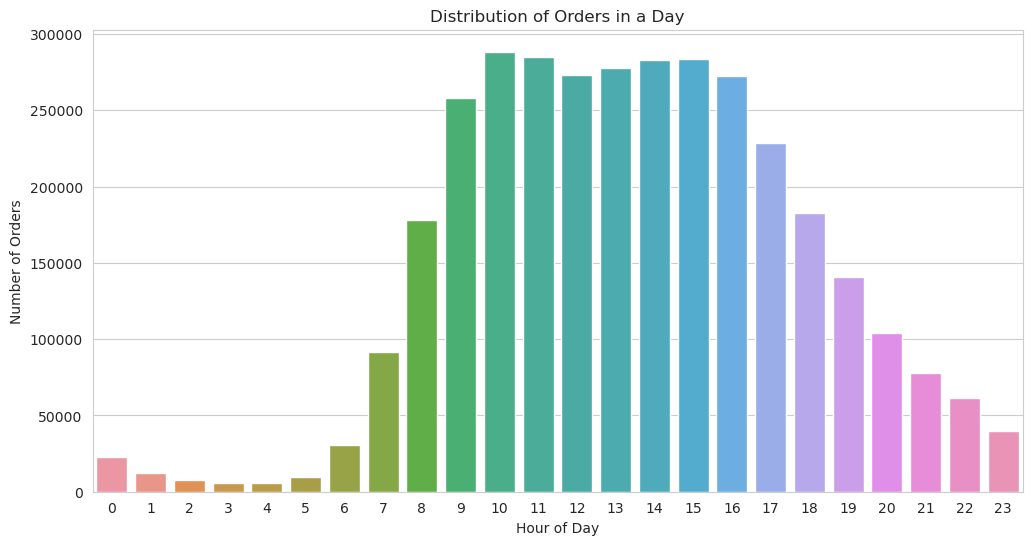

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up your PostgreSQL connection details
db_name = "InstaCart"
db_user = "nick"
db_password = "my_password"
db_host = "my_pgdb"
db_port = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=db_name, user=db_user, password=db_password, host=db_host, port=db_port)

# Define the SQL query
sql_query = """
SELECT order_hour_of_day, COUNT(*)
FROM public.orders
GROUP BY order_hour_of_day;
"""

# Read the data from the PostgreSQL database into a pandas DataFrame
orders_hourly = pd.read_sql_query(sql_query, conn)

# Close the connection
conn.close()

# Create a bar chart of the distribution of orders in a day
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=orders_hourly['order_hour_of_day'], y=orders_hourly['count'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders in a Day')
plt.xticks(range(0, 24))
plt.show()


That doesn't tell us much about shopping patterns except most people shop during business hour. If our goal is to segment users by shopping patterns in order to create promotional campaigns, then we need to try and find segments that makes sense. Be curious, inquistive, put yourself in the shoes of the customers, and the business owners, follow the logical next steps in your investigation. These are some the most important qualities as a data analyst.

So here in this case, are there users who only or mostly order during weekdays business hours? Or some who only order during after hours? Only on weekends? That sounds plausible, right? If there are such segments, then we can look into their baskets to see what they buy. Let's have a look. First we'll need to figure out which day is which as the provided data didn't specify that.


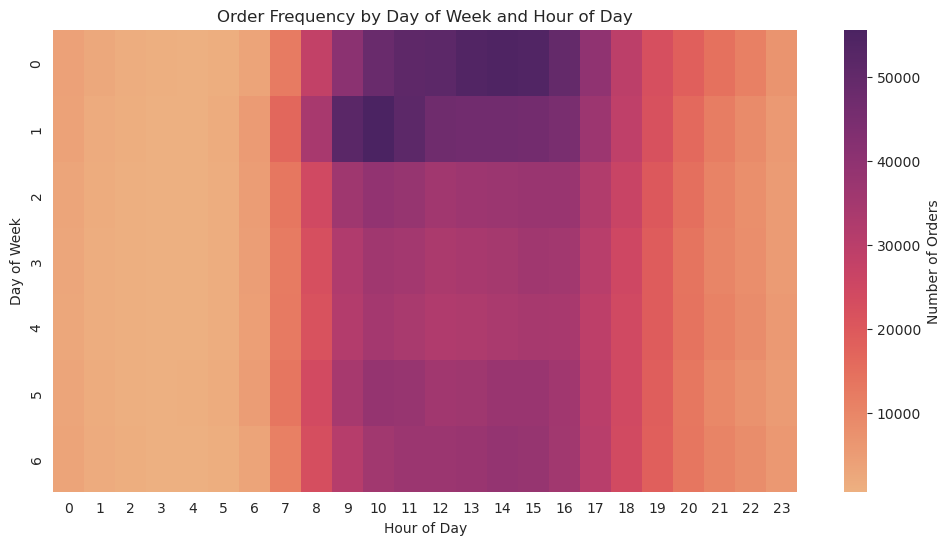

In [2]:
orders = pd.read_csv("orders.csv")

# Query the count of orders group by order_dow and order_hour_of_day
heatmap_data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].count().reset_index()

# Put result into pivot table
heatmap_table = heatmap_data.pivot(index='order_dow', columns='order_hour_of_day', values='order_id')

# Plot the heatmap using seaborn
plt.figure(figsize=(12, 6))
#sns.heatmap(heatmap_table, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Number of Orders'})
flare_cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(heatmap_table, cmap=flare_cmap, cbar_kws={'label': 'Number of Orders'})
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Order Frequency by Day of Week and Hour of Day')
plt.show()


It's still a little hard to guess, I was expecting more obvious dip on Friday and Saturday nights. I guess there is a tiny bit of that, so probably day 0 is Sunday, 1 is Monday and so on. Now we can try to segment the users by "when do they make most (80%) of their purchases?"

In [25]:
orders = pd.read_csv("orders.csv")

# Count orders for each user during the defined time segments
weekday_daytime = orders[(orders['order_dow'].isin(range(1, 6))) & (orders['order_hour_of_day'].isin(range(9, 18)))].groupby('user_id')['order_id'].count()
weekday_nighttime = orders[(orders['order_dow'].isin([1, 2, 3, 4, 5])) & ((orders['order_hour_of_day'] >= 18) | (orders['order_hour_of_day'] <= 8))].groupby('user_id')['order_id'].count()
weekends = orders[(orders['order_dow'].isin([0, 6]))].groupby('user_id')['order_id'].count()

# Get the total number of orders for each user
total_orders = orders.groupby('user_id')['order_id'].count()

# Combine the above into a data frame
user_order_segments = pd.concat([weekday_daytime, weekday_nighttime, weekends, total_orders], axis=1, keys=['weekday_daytime_count', 'weekday_nighttime_count', 'weekend_count', 'total_count'])
user_order_segments.fillna(0, inplace=True)

# Append percentage of orders for each user in each time segment to data frame
user_order_segments['weekday_daytime_percentage'] = user_order_segments['weekday_daytime_count'] / user_order_segments['total_count']
user_order_segments['weekday_nighttime_percentage'] = user_order_segments['weekday_nighttime_count'] / user_order_segments['total_count']
user_order_segments['weekend_percentage'] = user_order_segments['weekend_count'] / user_order_segments['total_count']

# Assign users to time segment groups (80% threshold)
def assign_group(row):
    if row['weekday_daytime_percentage'] >= 0.8:
        return 'Weekday Daytime'
    elif row['weekday_nighttime_percentage'] >= 0.8:
        return 'Weekday Nighttime'
    elif row['weekend_percentage'] >= 0.8:
        return 'Weekends'
    else:
        return 'Mixed'

user_order_segments['user_group'] = user_order_segments.apply(assign_group, axis=1)

# Now each user has been assigned a segment
print(user_order_segments[['user_group']])

              user_group
user_id                 
1                  Mixed
2        Weekday Daytime
3                  Mixed
4        Weekday Daytime
5                  Mixed
...                  ...
205853          Weekends
205936          Weekends
206007          Weekends
206134          Weekends
206191          Weekends

[206209 rows x 1 columns]


Let's see how customers are now distributed now:

In [30]:
group_count = user_order_segments['user_group'].value_counts()
group_count

Mixed                166731
Weekday Daytime       28984
Weekends               9266
Weekday Nighttime      1228
Name: user_group, dtype: int64

That adds up to 206K users, good! But we can also see that most users are in the mixed group. Let's plot this in a chart to visualize the differences.

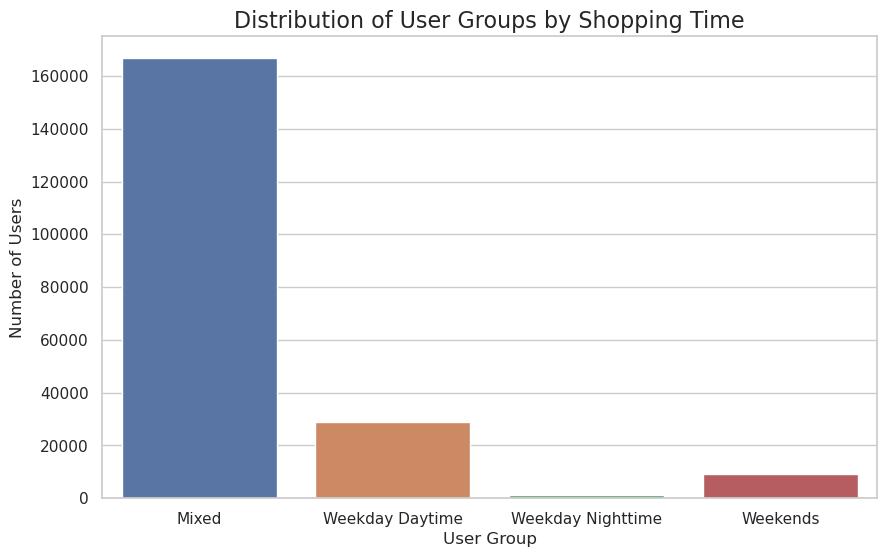

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=group_count.index, y=group_count.values, order=['Mixed', 'Weekday Daytime', 'Weekday Nighttime', 'Weekends'])

# Set plot title and labels
ax.set_title("Distribution of User Groups by Shopping Time", fontsize=16)
ax.set_xlabel("User Group", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)

# Show the plot
plt.show()


We can see that while most users shop on InstaCart in a mixed of hours throughout the day, there's a non insignificant amount of users who shop exclusively during weekday business hours! While we haven't discovered any meaningful insight in 1. **Customer Segmentation**, we have found something for 4. **Day and Time of Orders**. This information about an extra 14% of users during business hours can help us optimize our delivery schedules and staffing.

Data Analytics is detective work. You look at the circumstantial evidence and form your hypothesis, then you write codes to dig into the data to see if your hypothesis is correct. Often times they're not, but we just need to stay curious and inquistive. Learn from the result and form our next hypothesis.

So, what would be a logical next step? We could look at the order frequency. Perhaps when we compare the customers who order more frequently, we'll find correlation with the order time groups. You can think through how to do this before writing the codes. e.g.

1. Find the distrbution of average number of days between orders per user.
2. Eye ball that distribution and set up the segments that make sense to business.
3. Separate users into segments, explore differences in purchases (do pattern mining algorithms).

Can you see what are some of the benefits to going through data analysis in this approach, as opposed to blindly diving into pattern mining algorithms with the whole dataset? By dividing users into logical segments, we get a smaller but more relevant subset of data to run pattern mining algorithms through! (Better suggestions for user group. Better customer journey to move low tier customers to high tier.?)

For the purpose of demonstration, I'll just use the "Weekday Daytime" group we've already created above to continue and perform pattern mining.


## Edits

As part of this process, I created this "[csv-to-sql-copy](https://github.com/nicwn/conda-postgres/blob/master/csv-to-sql-copy.ipynb)" script in my toolkit to help me quickly inspect and import CSV files into Postgres.


As a product manager, I've had to jump into Jupyter notebooks from time to time to look into the data, but never had to maintain the data itself. Now, as I'm trying to switch back to hands on technical roles, I'll probably need to maintain my own development environments for different projects or clients. This gave me a great excuse to learn Docker and create my own toolkit :)

My goal is to be able to spin up Anaconda and PostgreSQL in Docker in one go. I use Logseq as my learning journal and documented my steps. Finally finished and pushed it to Github here https://github.com/nicwn/conda-postgres

With this, I can clone this repo into a new folder, download whatever dataset I need to work with, spin up a new container and import the dataset into Postgres or just dig in in a Jupyter notebook.

As someone with experience working across big corporations, startups and running my own small businesses, I understand all too well the disconnect between data analysts and business management. (Just knowing how to write queries and generating some generic charts is meaningless to business management who need that data to make business decisions.) I always begin my EDA with basic questions about the business: What kind of business is InstaCart? How does it make money? What are its expenses? What data is available? What are the short / long term goals of the business? What stage is the business in right now? What are the known hurdles? What would be interesting to the business? To the customers?… etc.

So, if you were a data analyst, what would you do first? I think a lot of us data geeks will be eager to jump into 2. **Product Associations** because we're itching to run some pattern mining algorithms! :) While I'm sure that'll yield some results, as an analyst, you should keep the high level goal of the company in mind before diving into time and resource intensive tasks, (like running FP-growth algorithm). Do a bit more high level EDA, check with the product team to see which areas are more relevant or higher in priority.



For patterns of when users do their shopping, we can look at the distribution of orders throughout a day like this:

```sql
SELECT order_hour_of_day, COUNT(*)
FROM public.orders
GROUP BY order_hour_of_day;
```

It'll be much easier to see this in a bar chart.

